# Inside Airbnb data load
Intial data load from Inside Airbnb.

The oldest data available has been used as this is the closest date to some of the other base datasets that will be used.  In this instance the data was published by Inside Airbnb on 10th December 2023 and accessed on 27th November 2024.

In [80]:
# load required packages
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import zipfile
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster, linkage
from dateutil.relativedelta import relativedelta
from datetime import datetime
from PIL import Image
import requests
from io import BytesIO
from shapely.geometry import Point
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200

In [143]:
# Set download URL for London data
# the date should be choosen by reviewing the Inside Airbnb Get Data page
# and identifying the date of the required data
date  = "2023-12-10"
url  = f"https://data.insideairbnb.com/united-kingdom/england/london/{date}/data/listings.csv.gz"

# create a dataframe of the raw Inside Airbnb data
df = pd.read_csv(url, compression='gzip', low_memory=False)

In [144]:
path = os.path.join('data','raw') # location to save the data
fn   = url.split('/')[-1] # return the file name
print(f"Writing to: {fn}")

if not os.path.exists(path):      # create directory if does not exist
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)

if not os.path.exists(os.path.join(path,fn)):  
    df.to_csv(os.path.join(path,fn), index=False)
    print("Done.")

else:
    print("Data previously downloaded")

Writing to: listings.csv.gz
Data previously downloaded


### Cleaning the data

In [145]:
# Column selection
# create list of columns required for further processing

# this is a list of all the columns in the dataset
# cols = ['id', 'listing_url', 'last_scraped', 'name', 'host_id', 'host_since', 'host_location', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 'first_review', 'last_review', 'reviews_per_month']

# this needs to be amended to contain the required columns
# currently only using minimal columns to ensure the process works
# define required columns
cols = ['id', 'listing_url', 'picture_url', 'host_id', "host_listings_count",'host_total_listings_count', 'property_type', 'room_type', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 'latitude', 'longitude', 'last_review', 'beds', 'bedrooms']

In [146]:
# check a testing data subset to work with
testing = False

if testing:
    df = pd.read_csv(os.path.join(path,fn), 
                low_memory=True, nrows=10000, usecols=cols)
else:
    df = pd.read_csv(os.path.join(path,fn), 
                low_memory=False,usecols=cols)

print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 91,778 x 18


In [147]:
# df["last_review"] = pd.to_datetime(df["last_review"])
# df.last_review.hist()
# df.last_review.isnull().value_counts()

In [148]:
def pick_active_listings(df, date='str', col="str"):
    """
    Converting review column to datetime, and selecting only the recently active listings. 
    Recently active is defined as those which received at least one review for the year precedeng the scrape.

    Arguments:
    date: string, format "%Y-%m-%d"
    dataframe
    col: string, colname with "last_review" or its alternative
    """
    df[col] = pd.to_datetime(df[col])
    date = datetime.strptime(date, "%Y-%m-%d")
    df = df[df['last_review'] > (date - relativedelta(years=1))] #| (df['last_review'].isnull())]
    
    print(f"Data frame after filtering last review date is {df.shape[0]:,} x {df.shape[1]}")
    return df

In [149]:
df = pick_active_listings(df, date, "last_review")

Data frame after filtering last review date is 46,749 x 18


In [150]:
df.sample(10, random_state=5)

,id,listing_url,picture_url,host_id,host_listings_count,host_total_listings_count,latitude,longitude,property_type,room_type,bedrooms,beds,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,last_review
84400,695420558467181551,https://www.airbnb.com/rooms/695420558467181551,https://a0.muscache.com/pictures/miso/Hosting-695420558467181551/original/93de9f9a-ce0c-43ef-9d49-9a91a5a6dbc1.jpeg,83138376,35.0,35.0,51.512820,-0.075120,Entire condo,Entire home/apt,NaN,1.0,$170.00,2,365,322,7,2023-07-10
5733,5177995,https://www.airbnb.com/rooms/5177995,https://a0.muscache.com/pictures/miso/Hosting-5177995/original/fd919995-6084-45c6-9163-64465c481d3e.jpeg,15697655,2.0,2.0,51.425004,-0.064657,Private room in rental unit,Private room,NaN,1.0,$65.00,2,365,84,1,2023-11-20
6014,9121307,https://www.airbnb.com/rooms/9121307,https://a0.muscache.com/pictures/0231b0f2-3a8e-4f77-b63d-0ad9dd9c0021.jpg,47524566,2.0,2.0,51.435350,-0.110800,Private room in home,Private room,NaN,1.0,$65.00,3,1125,15,62,2023-11-06
71180,53076272,https://www.airbnb.com/rooms/53076272,https://a0.muscache.com/pictures/9d53ca85-5c89-452d-9bf1-7794aa091688.jpg,429659191,1.0,1.0,51.525700,0.006870,Private room in home,Private room,NaN,1.0,$70.00,1,21,351,14,2023-07-09
79775,926953148305109326,https://www.airbnb.com/rooms/926953148305109326,https://a0.muscache.com/pictures/6b94c1b1-0656-4ce5-a0dd-10f42f0cb2b8.jpg,66596171,1.0,1.0,51.514070,0.019680,Entire condo,Entire home/apt,NaN,2.0,$111.00,1,1125,51,11,2023-11-30
77076,937469486010566508,https://www.airbnb.com/rooms/937469486010566508,https://a0.muscache.com/pictures/airflow/Hosting-937469486010566508/original/995e8253-2a4c-42e8-b2b4-6840b16210f0.jpg,3893507,5.0,7.0,51.528299,-0.050935,Entire rental unit,Entire home/apt,NaN,2.0,$145.00,2,365,165,11,2023-11-25
2108,906924808902274586,https://www.airbnb.com/rooms/906924808902274586,https://a0.muscache.com/pictures/92a7e833-6884-47a1-8816-c39932fcfc3b.jpg,467921785,3.0,3.0,51.508540,0.022453,Entire rental unit,Entire home/apt,NaN,3.0,$200.00,1,1125,349,4,2023-11-08
84939,903574709204439899,https://www.airbnb.com/rooms/903574709204439899,https://a0.muscache.com/pictures/miso/Hosting-903574709204439899/original/6cb22142-a437-4179-b1cf-ee64c3a16925.jpeg,33596727,2.0,7.0,51.488433,-0.144746,Private room in home,Private room,NaN,4.0,$575.00,3,1125,154,9,2023-12-10
37669,971131101603754139,https://www.airbnb.com/rooms/971131101603754139,https://a0.muscache.com/pictures/miso/Hosting-971131101603754139/original/96597a3a-ed9f-4fab-90b2-9fddbb8a21b6.jpeg,27483219,9.0,40.0,51.479806,-0.197162,Entire rental unit,Entire home/apt,NaN,4.0,$165.00,1,365,0,13,2023-12-03
72988,44046632,https://www.airbnb.com/rooms/44046632,https://a0.muscache.com/pictures/miso/Hosting-44046632/original/694a0c69-c0bb-4bed-9460-a7f648531c7d.jpeg,1957432,2.0,2.0,51.538850,-0.192210,Entire rental unit,Entire home/apt,NaN,1.0,$85.00,3,90,44,2,2023-10-21


In [151]:
df[~(df.price.str.startswith('$', na=False))]

,id,listing_url,picture_url,host_id,host_listings_count,host_total_listings_count,latitude,longitude,property_type,room_type,bedrooms,beds,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,last_review
2154,918515909028641020,https://www.airbnb.com/rooms/918515909028641020,https://a0.muscache.com/pictures/miso/Hosting-917980060635050826/original/27e9fca7-fad3-4495-a19f-cc3bce1cb4b6.jpeg,44546985,2.0,2.0,51.529280,-0.139670,Private room in rental unit,Private room,NaN,1.0,NaN,1,30,0,1,2023-08-18
2775,958765026009177756,https://www.airbnb.com/rooms/958765026009177756,https://a0.muscache.com/pictures/hosting/Hosting-958765026009177756/original/58039872-6a0c-4338-b766-908e5effc1fb.jpeg,33491544,1.0,3.0,51.526724,-0.078514,Entire rental unit,Entire home/apt,NaN,1.0,NaN,1,31,0,3,2023-10-24
3010,15402063,https://www.airbnb.com/rooms/15402063,https://a0.muscache.com/pictures/5aa94372-0575-4f92-9b73-e9b6b89276a5.jpg,98569729,1.0,1.0,51.568740,-0.340470,Private room in rental unit,Private room,NaN,1.0,NaN,1,30,0,101,2023-04-22
3375,24192437,https://www.airbnb.com/rooms/24192437,https://a0.muscache.com/pictures/bf3ca849-a6e2-49ab-b6f4-50b2c6bfcfe9.jpg,532362096,7.0,8.0,51.529220,-0.073050,Entire rental unit,Entire home/apt,NaN,1.0,NaN,3,1125,0,83,2023-10-29
8357,944617573370869658,https://www.airbnb.com/rooms/944617573370869658,https://a0.muscache.com/pictures/prohost-api/Hosting-944617573370869658/original/4eca1686-0679-4486-ae6a-831cb3b7a107.jpeg,444801189,38.0,41.0,51.496683,-0.163333,Entire rental unit,Entire home/apt,NaN,2.0,NaN,1,365,0,3,2023-11-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87762,35028558,https://www.airbnb.com/rooms/35028558,https://a0.muscache.com/pictures/miso/Hosting-35028558/original/c231308d-cb53-4bbf-9e91-907614af0743.jpeg,13567131,1.0,3.0,51.513680,-0.064770,Private room in rental unit,Private room,NaN,1.0,NaN,1,1125,0,86,2023-02-06
87834,41675596,https://www.airbnb.com/rooms/41675596,https://a0.muscache.com/pictures/b50b6d94-3c5a-490e-a482-d775c6607ed5.jpg,153738170,1.0,1.0,51.527120,-0.011520,Entire rental unit,Entire home/apt,NaN,3.0,NaN,2,1125,0,9,2023-01-03
89114,917980060635050826,https://www.airbnb.com/rooms/917980060635050826,https://a0.muscache.com/pictures/miso/Hosting-917980060635050826/original/27e9fca7-fad3-4495-a19f-cc3bce1cb4b6.jpeg,44546985,2.0,2.0,51.528856,-0.138242,Private room in rental unit,Private room,NaN,1.0,NaN,1,30,0,2,2023-09-30
89352,985578209248674801,https://www.airbnb.com/rooms/985578209248674801,https://a0.muscache.com/pictures/miso/Hosting-985578209248674801/original/606bc630-0285-4d38-9713-b70f7682d45e.jpeg,392987791,5.0,5.0,51.542191,-0.284209,Entire rental unit,Entire home/apt,NaN,2.0,NaN,2,365,0,1,2023-10-08


In [152]:
# Checked column data for na values
# df[df.price.isna()]

In [153]:
money = ['price']
for m in money:
    df[m] = df[m].str.replace(r'[$,]', '', regex=True).astype('float')

In [154]:
df

,id,listing_url,picture_url,host_id,host_listings_count,host_total_listings_count,latitude,longitude,property_type,room_type,bedrooms,beds,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,last_review
0,198258,https://www.airbnb.com/rooms/198258,https://a0.muscache.com/pictures/airflow/Hosting-198258/original/b283e62d-d939-4629-abcc-ab7ad5dcf77a.jpg,967537,1.0,1.0,51.534300,0.081780,Private room in rental unit,Private room,NaN,1.0,67.0,2,100,363,41,2023-03-16
2,42010,https://www.airbnb.com/rooms/42010,https://a0.muscache.com/pictures/airflow/Hosting-42010/original/aea0a1f2-220d-4321-ae61-1ef8b04822e0.jpg,157884,2.0,4.0,51.585900,-0.164340,Private room in home,Private room,NaN,1.0,65.0,4,365,208,556,2023-12-03
4,89870,https://www.airbnb.com/rooms/89870,https://a0.muscache.com/pictures/miso/Hosting-89870/original/1e68f3c3-0f1e-4283-954f-791cf0492caa.jpeg,54730,3.0,5.0,51.567920,-0.111250,Entire rental unit,Entire home/apt,NaN,1.0,149.0,1,60,357,133,2023-12-03
6,96052,https://www.airbnb.com/rooms/96052,https://a0.muscache.com/pictures/airflow/Hosting-96052/original/3fe1e247-2208-4e40-ac40-6e459280c371.jpg,448154,2.0,2.0,51.559300,-0.224970,Private room in condo,Private room,NaN,1.0,52.0,3,180,352,80,2023-11-24
8,390987,https://www.airbnb.com/rooms/390987,https://a0.muscache.com/pictures/8841768/8130b556_original.jpg,1955537,4.0,6.0,51.426430,-0.097260,Private room in home,Private room,NaN,1.0,41.0,14,1000,334,12,2023-07-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91770,950496843798716996,https://www.airbnb.com/rooms/950496843798716996,https://a0.muscache.com/pictures/71340c9b-0369-44de-82d6-a0d16a979439.jpg,529247253,4.0,4.0,51.542841,-0.089196,Private room in rental unit,Private room,NaN,1.0,61.0,1,1125,335,38,2023-12-01
91771,950514081689619834,https://www.airbnb.com/rooms/950514081689619834,https://a0.muscache.com/pictures/miso/Hosting-950514081689619834/original/e68de0d5-791f-49cd-a40f-a974a1740832.jpeg,486730857,69.0,102.0,51.520093,-0.210684,Entire rental unit,Entire home/apt,NaN,2.0,111.0,2,180,33,4,2023-11-26
91774,951178246905249947,https://www.airbnb.com/rooms/951178246905249947,https://a0.muscache.com/pictures/miso/Hosting-951178246905249947/original/09311848-7143-45dd-9080-8e943dcd8f8c.jpeg,211074697,7.0,13.0,51.480161,-0.114375,Entire rental unit,Entire home/apt,NaN,3.0,289.0,3,20,25,2,2023-09-10
91775,951188392382129035,https://www.airbnb.com/rooms/951188392382129035,https://a0.muscache.com/pictures/b4758d11-e7dd-4851-9c5b-edac37646ee1.jpg,526113148,2.0,2.0,51.478320,-0.180640,Entire home,Entire home/apt,NaN,4.0,400.0,1,365,227,2,2023-10-08


In [155]:
ints  = ['id', 'host_id', 'host_total_listings_count', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews']

for i in ints:
    print(f"Converting {i}")
    try:
        df[i] = df[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        df[i] = df[i].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting host_total_listings_count
Converting minimum_nights
Converting maximum_nights
Converting availability_365
Converting number_of_reviews


In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46749 entries, 0 to 91777
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         46749 non-null  int64         
 1   listing_url                46749 non-null  object        
 2   picture_url                46741 non-null  object        
 3   host_id                    46749 non-null  int64         
 4   host_listings_count        46749 non-null  float64       
 5   host_total_listings_count  46749 non-null  int64         
 6   latitude                   46749 non-null  float64       
 7   longitude                  46749 non-null  float64       
 8   property_type              46749 non-null  object        
 9   room_type                  46749 non-null  object        
 10  bedrooms                   6 non-null      float64       
 11  beds                       46295 non-null  float64       
 12  price    

In [157]:
# split the data into valid prices and NaN data
df_valid = df[~df['price'].isna()] # rows where price is valid
df_nan = df[df['price'].isna()] # rows where price is NaN
df_valid.shape[0]

46688

In [158]:
def find_duplicates(df_valid):
    """
    The function looks at hosts with multiple listings and checks if they are within 300m radius (150m max location scattering as per Airbnb's anonymisation algorithm, x2).
    It then estimates the number of genuine homes within the cluster.
    
    Returns a gdf with new columns: 
    'cluster_id' - each unique value is a cluster
    'easting', 'northing' - used in calculating the proximity of listings
    'prvt_rms_in_cluster','entr_hms_in_cluster' - summarises N of private rooms and entire homes within the cluster
    'genuine', 'true_nrooms' - boolean column, and int column, with the following assumptions:

    If the cluster has 0 entire homes, and N rooms, first room will be "converted" to an entire home, and the rest will be discarded. 
    The location of the point will be amended to represent centrepoint of all rooms in the cluster.
    Record of the N of rooms will stay in col "true_nrooms"
    If the cluster has rooms and entire homes, the homes will be treated as genuine homes, and rooms treated as duplicates of the genuine home. 
    With the current timeframes, further enquiries into uniqueness of homes vs rooms inside each cluster is not feasible.
    """
    """
    We are looking for duplicates among multi-listing hosts. First, we filter by listings_count > 1.
    """
    finddups = df_valid[df_valid["host_listings_count"] > 1]
    print(f"There are {finddups.shape[0]} listings from multi-lister hosts")
    
    """
    I convert the df into gdf, reproject into EPSG 27700, and put easting and northing into new columns.
    """
    finddupsgdf = gpd.GeoDataFrame(finddups,
          geometry=gpd.points_from_xy(finddups.longitude, finddups.latitude, crs='epsg:4326'))
    
    finddupsgdf = finddupsgdf.set_crs('EPSG:4326', allow_override=True)
    finddups = finddupsgdf.to_crs('EPSG:27700', inplace=True)
    # print(finddupsgdf.crs)
    # finddupsgdf.plot()
    
    # null values in N of bedrooms will interfere with our analysis, therefore we drop them
    finddupsgdf = finddupsgdf[finddupsgdf.beds.notna()]
    print(f"Data frame after filtering bedrooms Nans is {len(finddupsgdf)} listings long")
    
    finddupsgdf['easting'] = finddupsgdf.geometry.x
    finddupsgdf['northing'] = finddupsgdf.geometry.y
    # Initialize columns
    finddupsgdf['prvt_rms_in_cluster'] = finddupsgdf['beds']
    finddupsgdf['entr_hms_in_cluster'] = 0
    finddupsgdf['cluster_id'] = None
    finddupsgdf['true_nrooms'] = finddupsgdf['beds']
    finddupsgdf['genuine'] = True
    
    """
    I perform cluster analysis a1nd mark listings from the same host that are within 300m from each other 
    (150m max location scattering as per Airbnb's anonymisation algorithm, x2). They constitute a cluster, and we then assess if they are a duplicate or not.
    The selected method computes pairwise distances  can calculate the distance matrix between all points in a group. 
    Before this method I tried KNN, but the listings were paired incorrectly. 
    cdist solved this, and it is relatively light on small groups (our dataset is large, but it is split into small groups - by host).
    """
    # Process each host group
    for host_id, group in finddupsgdf.groupby("host_id"):
        if len(group) > 1:  # Only proceed if there is more than 1 listing
            coords = group[['easting', 'northing']].to_numpy()
            
            # Calculate pairwise distances using pdist (returns condensed distance matrix)
            dist_matrix = pdist(coords)
            
            # Perform hierarchical clustering using the condensed distance matrix
            linkage_matrix = linkage(dist_matrix, method='single')
            clusters = fcluster(linkage_matrix, t=300, criterion='distance')
            
            # Assign clusters back to the original GeoDataFrame
            finddupsgdf.loc[group.index, 'cluster_id'] = [f"{host_id}-{cluster}" for cluster in clusters]
        else:
            finddupsgdf.loc[group.index, 'cluster_id'] = None  # Single point, no clustering
    
    #creating gdf with clusters only
    finddupsgdf1 = finddupsgdf[~finddupsgdf['cluster_id'].isna()]
    finddupsgdf1 = finddupsgdf1.loc[finddupsgdf.duplicated(subset='cluster_id', keep=False)]
    
    print(f"Found {len(set(finddupsgdf1.cluster_id))} clusters.")
    
    """
    I calculate N of entire homes and rooms in each cluster.
    Limitation found during EDA: "bedrooms" column in InsideAirbnb differs between scrapes. 
    "2023-12-10" scrape has NaN values in this column, while "2024-09-06" scrape has full data.
    For both datasets, we use "beds" column as a substitute, because airbnb2024.bedrooms.median()/airbnb2024.beds.median() = 1
    """
    # Loop through each cluster by cluster_id. 
    for i, group in finddupsgdf1.groupby("cluster_id"):
        # Count number of entire homes and private rooms in the group
        n_entire_homes = group[group['room_type'] == 'Entire home/apt'].shape[0]
        n_private_rooms = group[group['room_type'] == 'Private room'].shape[0]
    
        # Assign these counts back to the original DataFrame
        finddupsgdf1.loc[group.index, 'entr_hms_in_cluster'] = n_entire_homes
        finddupsgdf1.loc[group.index, 'prvt_rms_in_cluster'] = n_private_rooms
    
    for i, group in finddupsgdf1.groupby("cluster_id"):
        # If there are no "Entire home/apt" listings, only rooms. We assume they combine into an entire home, or are a large-scale commercial let
        if (group['entr_hms_in_cluster'] == 0).any(): #using any because the values are the same within the group
            finddupsgdf1.loc[group.index, 'true_nrooms'] = len(group)
    
    #finddupsgdf.true_nrooms.hist(range={1,10})
    
    print(f"There are {finddupsgdf1[finddupsgdf1['true_nrooms'] > 6].shape[0]} listings that are within clusters with more than 6 listings in each. These are likely to be flats converted to holiday accommodation. We are leaving them in for the purpose of the exercise. They belong to {len(set(finddupsgdf[finddupsgdf['true_nrooms'] > 6].host_id))} unique host IDs.")
    """
    I then determine whether listings are genuine unique homes, or rooms from one entire home.
    If the cluster has 0 entire homes, and N rooms, first room will be "converted" to an entire home, and the rest will be discarded.
    Record of the N of rooms will stay in col "true_nrooms"
    If the cluster has rooms and entire homes, the homes will be treated as genuine homes, and rooms treated as duplicates of the genuine home
    """
    
    for cluster_id, group in finddupsgdf1.groupby("cluster_id"):
        
        num_entire_homes = (group['room_type'] == 'Entire home/apt').sum()
        
        if num_entire_homes == 0:
            # If only rooms are in the cluster
            finddupsgdf1.loc[group.index, 'genuine'] = False  # Mark all as duplicates
            first_room_idx = group.index[0]  # Pick the first room as genuine
            finddupsgdf1.loc[first_room_idx, 'genuine'] = True  # First room becomes the genuine home
            """ ... but the geometry is replaced with centroid x and y. 
            Without this the point and all associated rooms can be aggregated by different spatial unit, considering the scale of the location approximation (up to 150m from origin)"""
            dissolved_geometry = group.geometry.union_all()  # Combine all geometries in the group
            centroid = dissolved_geometry.centroid # Get the centroid of the combined geometry
            finddupsgdf1.at[first_room_idx, 'geometry'] = Point(centroid.x, centroid.y)
        else:
            # Cluster has both rooms and entire homes
            finddupsgdf1.loc[group.index, 'genuine'] = False  # Default all to duplicates
            entire_home_indices = group[group['room_type'] == 'Entire home/apt'].index
            finddupsgdf1.loc[entire_home_indices, 'genuine'] = True  # Mark entire homes with true

    # write valid data to be used in further analysis
    # fn = {date}+"inside_airbnb_clean.csv"
    # path = os.path.join('data','inside_airbnb')
    
    # if not os.path.exists(path):
    #     print(f"Creating {path} under {os.getcwd()}")
    #     os.makedirs(path)
        
    # df_valid.to_file(os.path.join(path,fn), index=False)

    print(f"The clustering exercise identified {len(finddupsgdf1[finddupsgdf1['genuine'] == False])} listings that are potentially duplicates of other listings.")
    #print(f"The gdf has been saved into {path}")
    finddupsgdf.update(finddupsgdf1)

    return finddupsgdf

In [159]:
df_valid_nodups = find_duplicates(df_valid)
df_valid_nodups[['genuine']].value_counts()

There are 30362 listings from multi-lister hosts
Data frame after filtering bedrooms Nans is 30024 listings long
Found 6202 clusters.
There are 1188 listings that are within clusters with more than 6 listings in each. These are likely to be flats converted to holiday accommodation. We are leaving them in for the purpose of the exercise. They belong to 209 unique host IDs.
The clustering exercise identified 6383 listings that are potentially duplicates of other listings.


genuine
True       23641
False       6383
Name: count, dtype: int64

In [160]:
df_valid_nodups[['genuine']].value_counts()

genuine
True       23641
False       6383
Name: count, dtype: int64

In [161]:
df_valid_nodups.head(1)

,id,listing_url,picture_url,host_id,host_listings_count,host_total_listings_count,latitude,longitude,property_type,room_type,bedrooms,beds,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,last_review,geometry,easting,northing,prvt_rms_in_cluster,entr_hms_in_cluster,cluster_id,true_nrooms,genuine
2,42010,https://www.airbnb.com/rooms/42010,https://a0.muscache.com/pictures/airflow/Hosting-42010/original/aea0a1f2-220d-4321-ae61-1ef8b04822e0.jpg,157884,2.0,4,51.5859,-0.16434,Private room in home,Private room,NaN,1.0,65.0,4,365,208,556,2023-12-03,POINT (527404.384 188986.1),527272.234429,189045.092972,2.0,0,157884-1,2.0,True


In [172]:
# Let's check if the find_duplicates works

import base64  # Add this import at the top
import IPython.display as display
import random
def check_genuine(df, **kwargs):
    """
    Receives df and random_state as args.
    Displays the random ingenuine listing, and other listings from its cluster.
    Shows image thumbnails for all listings in the cluster, with clickable URLs displayed above the images.
    """
    if not kwargs.get('random_state'):
        random_state = random.randint(0,1000)
    else:
        random_state = kwargs.get('random_state')
    print(f'random_state:{random_state}')
    # Select a random "ingenuine" listing from the dataset
    listing_check = df[df['genuine'] == False].sample(1, random_state=random_state)
    
    print(f"Let's have a look at the random listing. ID: {listing_check.id.values[0]}")
    print(f"Cluster number {listing_check.cluster_id.values[0]}")
    print("All listings in this cluster:")
    
    # Get all listings in the same cluster
    same_cluster = df[df["cluster_id"] == listing_check.cluster_id.values[0]]
    # print(same_cluster[["id", "listing_url"]])
    
    # Collect successful images and their associated URLs
    successful_images = []
    urls = []
    
    for idx, row in same_cluster.iterrows():
        try:
            response = requests.get(row['picture_url'], timeout=10)
            response.raise_for_status()  # Raise an error for HTTP issues
            img = Image.open(BytesIO(response.content))
            img.thumbnail((190, 190))  # Resize image for thumbnail display
            successful_images.append((img, row['listing_url']))
        except Exception as e:
            print(f"Failed to retrieve image for Listing ID: {row['id']}. Error: {e}")
    
    # If no successful images, return early
    if not successful_images:
        print("No images could be retrieved.")
        return
    
    # Render images and clickable links in Quarto Markdown
    html_content = "<table>"
    for i, (img, url) in enumerate(successful_images):
        if i % 3 == 0:  # Start a new row every 3 images
            html_content += "<tr>"
        
        # Convert the image to a data URL
        img_buffer = BytesIO()
        img.save(img_buffer, format="PNG")
        img_data = img_buffer.getvalue()
        img_base64 = base64.b64encode(img_data).decode('utf-8')  # Encoding the image
        img_src = f"data:image/png;base64,{img_base64}"
        
        # Add the image and link to the HTML
        html_content += f"""
        <td style="text-align:center; padding:5px">
            <a href="{url}" target="_blank"><img src="{img_src}" style="width:128px; height:auto; border:1px solid #ccc" /></a>
        </td>
        """
        if i % 3 == 2:  # End the row every 3 images
            html_content += "</tr>"
    
    html_content += "</table>"
    
    # Display the HTML in Quarto
    display.display(display.HTML(html_content))

random_state:10
Let's have a look at the random listing. ID: 737735186226225920
Cluster number 479514832-1
All listings in this cluster:
Failed to retrieve image for Listing ID: 715904127243810688. Error: 403 Client Error: Forbidden for url: https://a0.muscache.com/pictures/bc9338a5-7325-46bb-bd67-12d92779c484.jpg


,

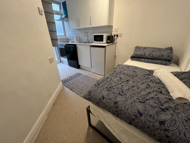
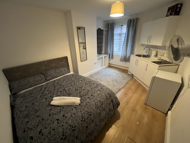

In [177]:
check_genuine(df_valid_nodups,random_state=10)

Let's have a look at the random listing. ID: 6225592
Cluster number 32287428-1
All listings in this cluster:


,

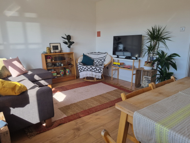
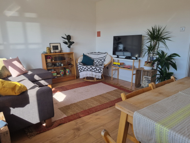

In [163]:
check_genuine(df_valid_nodups, 8)

random_state:554
Let's have a look at the random listing. ID: 36914727
Cluster number 20422553-7
All listings in this cluster:


,,

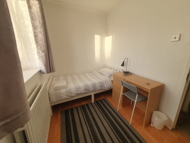
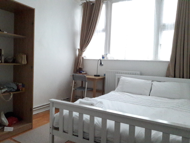
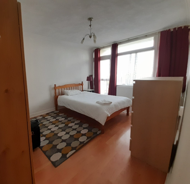

In [178]:
check_genuine(df_valid_nodups)

random_state:510
Let's have a look at the random listing. ID: 1032683903535838080
Cluster number 545429981-1
All listings in this cluster:
Failed to retrieve image for Listing ID: 1019627277341748608. Error: 403 Client Error: Forbidden for url: https://a0.muscache.com/pictures/miso/Hosting-1019627277341748572/original/6dae3759-b1f7-4740-afe1-364f02b19d5f.png


,,

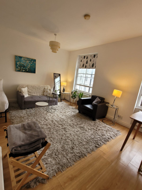
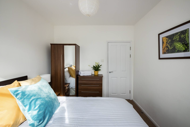
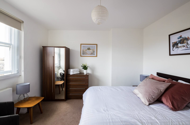

In [180]:
check_genuine(df_valid_nodups)

Let's have a look at the random listing. ID: 864704403774497536
Cluster number 357922045-1
All listings in this cluster:



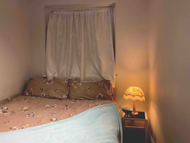
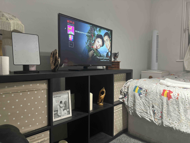
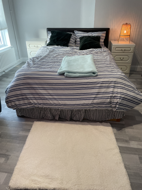
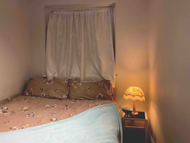

In [166]:
check_genuine(df_valid_nodups, 1)

In [76]:
    """
    Will not be needed once we join filles
    """
# # write valid data to be used in further analysis
# fn = "inside_airbnb_clean.csv"
# path = os.path.join('data','inside_airbnb')

# if not os.path.exists(path):
#     print(f"Creating {path} under {os.getcwd()}")
#     os.makedirs(path)
    
# df_valid.to_csv(os.path.join(path,fn), index=False)
# print("Done.")

'\nWill not be needed once we join filles\n'